# Not Hotdog App with fast.ai
> In this post we will be using <a href="https://course.fast.ai/index.html/">fast.ai</a> to recreate the "Not Hotdog" app featured in the tv show "Silicon Valley". The fastai library simplifies training fast and accurate neural nets using modern best practices.  

- toc: true 
- badges: true
- comments: true
- categories: [jupyter, pandas, keras, reddit, deep-learning]
- image: images/undraw_barbecue.svg

<p>The code for this project can be found <a href="https://github.com/gardnmi/prophet/blob/master/Stock%20Price%20Forecast%20with%20Prophet.ipynb">here.</a></p>

<hr />
<h3 id="imports">Imports</h3>

In [1]:
from fastai.vision import *
from google_images_download import google_images_download

fasai handles all the dependencies for you.  You simply call <code> from fastai.vision import * </code> and that is it.  I also imported a library called <code> google_images_download </code> which I will use next to download our imageset from google images.

<hr />
<h3 id="Data-Preparation">Data Preparation</h3>

<p><img src="https://i.imgur.com/Hty3WCz.png" class="img-fluid" alt="Responsive image" /></p>



In [2]:
! googleimagesdownload -cf google_config.json

<p><img src="https://i.imgur.com/XD7yc90.png" class="img-fluid" alt="Responsive image" /></p>

For our Not Hotdog app to work we are going to need to train it with images of hotdogs and "not hotdogs".  To get the images we use the library <code> googleimagesdownload </code>.  The json file above are parameters for the library.  We are essentially telling it to Query Google Images once for "hotdog" and download the first 100 images into a folder called "images/hotdog" and then again for "random pictures" and store them in a folder called "images/not_hotdog".

We execute the code by calling <code> ! googleimagesdownload -cf google_config.json </code>  We now have the images we need for our deep learning model.

In [3]:
path = Path('images')

data = ImageDataBunch.from_folder(path, 
                                  train=['hotdog', 'not_hotdog'], 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(), 
                                  size=224, 
                                  num_workers=0).normalize(imagenet_stats)

fastai uses a "Learner" object to train a model.  In order to establish a learner with your data you first need to create a "ImageDataBunch" object. 

Above we:
<ul>
<li>Set the path for the location of the image folders</li>
<li>Provide the names of the two folders we are labeling</li>
<li>Create a validation set from out images using 20% of them as validation</li>
<li>Transform the Images</li>
<li>Set the size of the Images</li>
<li>Normalize the Data</li>
</ul>

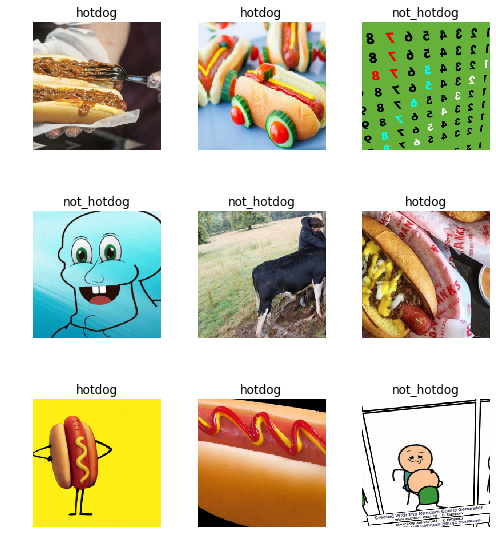

In [4]:
data.show_batch(rows=3, figsize=(7,8))

In [5]:
print(
f'Labels: {data.classes}\n'
f'Training Set Size: {len(data.train_ds)}\n'
f'Validation Set Size: {len(data.valid_ds)}'
)

Labels: ['hotdog', 'not_hotdog']
Training Set Size: 143
Validation Set Size: 35


Now that we have our databunch created <code>data</code> we can preview our transformed / normalized images.  We can also access the Labels that we are trying to predict as well as the train and validation sizes.

<hr />
<h3 id="#Training">Training</h3>

In [6]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,error_rate,time
0,1.066794,1.197378,0.485714,01:23
1,0.675965,0.504514,0.200000,01:23
2,0.495727,0.335483,0.142857,01:17
3,0.387999,0.246207,0.085714,01:19


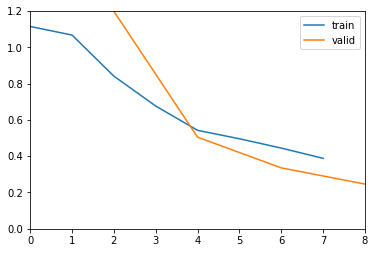

In [7]:
learn.fit_one_cycle(4)

In [8]:
learn.save('stage-1')

To train our model we create a <code> cnn_learner </code> which specializes in image labeling.  We pass in the databunch we created earlier <code> data </code> and then use the default arguments found in the documentation. 

We then fit the model using <code> learn.fit_one_cycle(4) </code>.  As you can see each time the dataset is trained (epoch) the model performance get slightly better.

Finally we save the current iteration of the model just in case. 

In [9]:
learn.unfreeze()

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


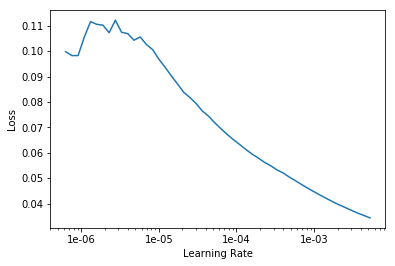

In [11]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.132134,0.168690,0.057143,01:40
1,0.101042,0.126670,0.057143,01:35


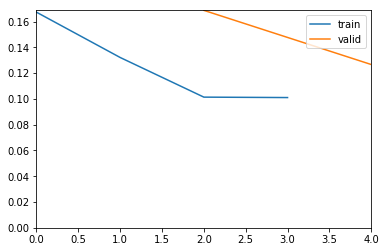

In [12]:
learn.fit_one_cycle(2, max_lr=slice(1e-05, 1e-04))

In [13]:
learn.save('stage-2')

<p>The next step is to optimize our model using the learning rate finder.  The learning rate is what tells our model how fast or how slow it should minimize loss.  A learning rate to high might never find the minimum loss and too low and it could take too long.</p>

<p>We call <code> learn.lr_find()</code> and then <code> learn.recorder.plot() </code>.  According to the documentation we are supposed to pick out a range on the plot that has the steepest slope.  I'm still a little unsure about this but I opt for the range of "1e-05 to 1e-04".</p>

<p>We then fit the model one last time using the new learning rate range.</p>

<hr />
<h3 id="#Evaluation">Evaluation</h3>

In [14]:
# learn.load('stage-2')

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

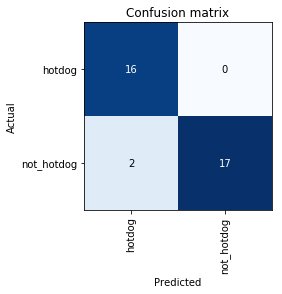

In [16]:
interp.plot_confusion_matrix()

Now that our model is sufficiently trained let's check the results of the validation set with a Confusion Matrix.  As you can see below we have 2 wrong predictions where our model thought the picture was a "hotdog" when in fact it was a "not_hotdog".

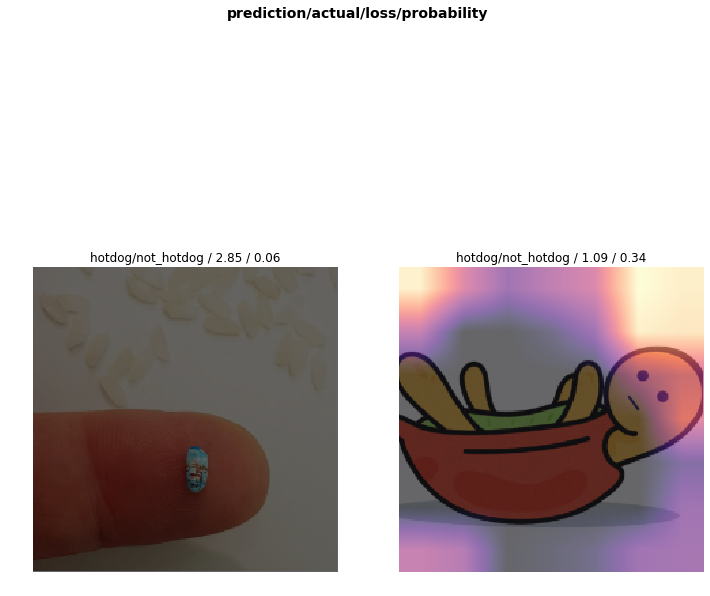

In [20]:
interp.plot_top_losses(2)

By calling <code> interp.plot_top_losses(2) </code> we can see the two images that were incorrectly labeled.  As you can see both images somewhat resemble the shape of a hotdog.

<hr />

<h3 id="#Prediction">Prediction</h3>

<p><img src="https://i.imgur.com/FZ9jEd3.png" class="img-fluid" alt="Responsive image" /></p>

In [21]:
hotdog =  open_image(r'test\hotdog.png')
hamburger =  open_image(r'test\hamburger.jpg')
dog = open_image(r'test\puppy.jpg')

In [22]:
for name, img in zip(['hotdog', 'hamburger', 'dog'], [hotdog, hamburger, dog]):
    
    pred_class, _ , _ = learn.predict(img)
    print(f'{name} is {pred_class}')

hotdog is hotdog
hamburger is hotdog
dog is not_hotdog


The last step in the process is using our model to actually predict new images.  Above I import 3 new images using <code> open_image </code>.  We then use <code>  learn.predict </code> on our images which returns the class we are predicting, its index, and the probability.  We are only interested in the class so we put an underscore "_" for the other two.  

As you can see it accurately identifies the hotdog as a "hotdog" and the dog as a "not_hotdog".  Unfortunately, the hamburger is labeled incorrectly but as you can see it does sort of resemble a hotdog.  The next steps would be to continue to iterate on the model by adding more images and tuning parameters.

<hr />

<h3 id="#Summary">Summary</h3>

fastai makes it very easy for anyone that wants to be a practitioner of deep learning. It allows the user to create very accurate models that a few years ago would have been considered state of the art.  The fastai library is very well documented and has plenty of examples to follow along with.  I highly recommend you check it out.